In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import io
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = '/content/drive/My Drive/Colab Notebooks/Tensor_decom_sample/data/'

In [3]:
data=pd.read_csv(data_path + 'tripcsvbame.csv')

In [4]:
data['usage-stats/'][:2]

0         01aJourneyDataExtract10Jan16-23Jan16.csv
1     01b Journey Data Extract 24Jan16-06Feb16.csv
Name: usage-stats/, dtype: object

In [5]:
dat=data['usage-stats/'][:2]
frames=[]
for x in dat:
    frames.append(pd.read_csv(data_path + x[1:]))

result = pd.concat(frames)
result.columns

Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id',
       'StartStation Name'],
      dtype='object')

In [6]:
date_format = '%d/%m/%Y %H:%M:%S'
result['End Date']=pd.to_datetime(result['End Date'])
result['Start Date']=pd.to_datetime(result['Start Date'])
result

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,50754225,240,11834,2016-10-01 00:04:00,383.0,"Frith Street, Soho",2016-10-01 00:00:00,18,"Drury Lane, Covent Garden"
1,50754226,300,9648,2016-10-01 00:05:00,719.0,"Victoria Park Road, Hackney Central",2016-10-01 00:00:00,479,"Pott Street, Bethnal Green"
2,50754227,1200,10689,2016-10-01 00:20:00,272.0,"Baylis Road, Waterloo",2016-10-01 00:00:00,425,"Harrington Square 2, Camden Town"
3,50754228,780,8593,2016-10-01 00:14:00,471.0,"Hewison Street, Old Ford",2016-10-01 00:01:00,487,"Canton Street, Poplar"
4,50754229,600,8619,2016-10-01 00:11:00,399.0,"Brick Lane Market, Shoreditch",2016-10-01 00:01:00,501,"Cephas Street, Bethnal Green"
...,...,...,...,...,...,...,...,...,...
292694,51360634,600,10400,2016-07-02 00:07:00,48.0,"Godliman Street, St. Paul's",2016-06-02 23:57:00,388,"Southampton Street, Strand"
292695,51360635,240,2320,2016-07-02 00:01:00,574.0,"Eagle Wharf Road, Hoxton",2016-06-02 23:57:00,73,"Old Street Station, St. Luke's"
292696,51360636,720,11143,2016-07-02 00:09:00,535.0,"Gloucester Avenue, Camden Town",2016-06-02 23:57:00,109,"Soho Square , Soho"
292697,51360637,900,6848,2016-07-02 00:14:00,732.0,"Duke Street Hill, London Bridge",2016-06-02 23:59:00,443,"Philpot Street, Whitechapel"


In [7]:
results_f = result[result['Duration']<86400]

In [8]:
results_f

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,50754225,240,11834,2016-10-01 00:04:00,383.0,"Frith Street, Soho",2016-10-01 00:00:00,18,"Drury Lane, Covent Garden"
1,50754226,300,9648,2016-10-01 00:05:00,719.0,"Victoria Park Road, Hackney Central",2016-10-01 00:00:00,479,"Pott Street, Bethnal Green"
2,50754227,1200,10689,2016-10-01 00:20:00,272.0,"Baylis Road, Waterloo",2016-10-01 00:00:00,425,"Harrington Square 2, Camden Town"
3,50754228,780,8593,2016-10-01 00:14:00,471.0,"Hewison Street, Old Ford",2016-10-01 00:01:00,487,"Canton Street, Poplar"
4,50754229,600,8619,2016-10-01 00:11:00,399.0,"Brick Lane Market, Shoreditch",2016-10-01 00:01:00,501,"Cephas Street, Bethnal Green"
...,...,...,...,...,...,...,...,...,...
292694,51360634,600,10400,2016-07-02 00:07:00,48.0,"Godliman Street, St. Paul's",2016-06-02 23:57:00,388,"Southampton Street, Strand"
292695,51360635,240,2320,2016-07-02 00:01:00,574.0,"Eagle Wharf Road, Hoxton",2016-06-02 23:57:00,73,"Old Street Station, St. Luke's"
292696,51360636,720,11143,2016-07-02 00:09:00,535.0,"Gloucester Avenue, Camden Town",2016-06-02 23:57:00,109,"Soho Square , Soho"
292697,51360637,900,6848,2016-07-02 00:14:00,732.0,"Duke Street Hill, London Bridge",2016-06-02 23:59:00,443,"Philpot Street, Whitechapel"


In [9]:
result=results_f.dropna()
new_result=result.set_index('Start Date').groupby([pd.Grouper(freq='h'), 'StartStation Name', 'EndStation Name']).count()
new_result

Rental Id  \
Start Date          StartStation Name                 EndStation Name                                          
2016-01-02 00:00:00 Abbey Orchard Street, Westminster Eccleston Place, Victoria                            2   
                    Abingdon Villas, Kensington       Gloucester Road (Central), South Kensington          1   
                    Aintree Street, Fulham            Imperial Road, Sands End                             1   
                    BBC White City, White City        Crisp Road, Hammersmith                              2   
                    Baldwin Street, St. Luke's        Queen Mary's, Mile End                               1   
...                                                                                                      ...   
2016-12-01 23:00:00 Windsor Terrace, Hoxton           Leonard Circus , Shoreditch                          1   
                    Winsland Street, Paddington       Turquoise Island, Notting Hill                       1   
                    Woodstock Street, Mayfair         Murray Grove , Hoxton                                1   
                    Wormwood Street, Liverpool Street Bank of England Museum, Bank                         1   
                    Wright's Lane, Kensington         Danvers Street, West Chelsea                         1   

                                                                                                   Duration  \
Start Date          StartStation Name                 EndStation Name                                         
2016-01-02 00:00:00 Abbey Orchard Street, Westminster Eccleston Place, Victoria                           2   
                    Abingdon Villas, Kensington       Gloucester Road (Central), South Kensington         1   
                    Aintree Street, Fulham            Imperial Road, Sands End                            1   
                    BBC White City, White City        Crisp Road, Hammersmith                             2   
                    Baldwin Street, St. Luke's        Queen Mary's, Mile End                              1   
...                                                                                                     ...   
2016-12-01 23:00:00 Windsor Terrace, Hoxton           Leonard Circus , Shoreditch                         1   
                    Winsland Street, Paddington       Turquoise Island, Notting Hill                      1   
                    Woodstock Street, Mayfair         Murray Grove , Hoxton                               1   
                    Wormwood Street, Liverpool Street Bank of England Museum, Bank                        1   
                    Wright's Lane, Kensington         Danvers Street, West Chelsea                        1   

                                                                                                   Bike Id  \
Start Date          StartStation Name                 EndStation Name                                        
2016-01-02 00:00:00 Abbey Orchard Street, Westminster Eccleston Place, Victoria                          2   
                    Abingdon Villas, Kensington       Gloucester Road (Central), South Kensington        1   
                    Aintree Street, Fulham            Imperial Road, Sands End                           1   
                    BBC White City, White City        Crisp Road, Hammersmith                            2   
                    Baldwin Street, St. Luke's        Queen Mary's, Mile End                             1   
...                                                                                                    ...   
2016-12-01 23:00:00 Windsor Terrace, Hoxton           Leonard Circus , Shoreditch                        1   
                    Winsland Street, Paddington       Turquoise Island, Notting Hill                     1   
                    Woodstock Street, Mayfair         Murray Grove , Hoxton                       

In [10]:
new_result['No of trips']=new_result['Duration']
new_result.drop(columns=['Rental Id'],inplace=True)
new_result.drop(columns=['Duration'],inplace=True)
new_result.drop(columns=['Bike Id'],inplace=True)
new_result.drop(columns=['End Date'],inplace=True)
new_result.drop(columns=['EndStation Id'],inplace=True)
new_result.drop(columns=['StartStation Id'],inplace=True)
new_result

No of trips
Start Date          StartStation Name                 EndStation Name                                         
2016-01-02 00:00:00 Abbey Orchard Street, Westminster Eccleston Place, Victoria                              2
                    Abingdon Villas, Kensington       Gloucester Road (Central), South Kensington            1
                    Aintree Street, Fulham            Imperial Road, Sands End                               1
                    BBC White City, White City        Crisp Road, Hammersmith                                2
                    Baldwin Street, St. Luke's        Queen Mary's, Mile End                                 1
...                                                                                                        ...
2016-12-01 23:00:00 Windsor Terrace, Hoxton           Leonard Circus , Shoreditch                            1
                    Winsland Street, Paddington       Turquoise Island, Notting Hill                         1
                    Woodstock Street, Mayfair         Murray Grove , Hoxton                                  1
                    Wormwood Street, Liverpool Street Bank of England Museum, Bank                           1
                    Wright's Lane, Kensington         Danvers Street, West Chelsea                           1

[517741 rows x 1 columns]

In [11]:
df = new_result.reset_index()
df = df.sort_values(by=['Start Date'])
df = new_result.reset_index()
df

,Start Date,StartStation Name,EndStation Name,No of trips
0,2016-01-02 00:00:00,"Abbey Orchard Street, Westminster","Eccleston Place, Victoria",2
1,2016-01-02 00:00:00,"Abingdon Villas, Kensington","Gloucester Road (Central), South Kensington",1
2,2016-01-02 00:00:00,"Aintree Street, Fulham","Imperial Road, Sands End",1
3,2016-01-02 00:00:00,"BBC White City, White City","Crisp Road, Hammersmith",2
4,2016-01-02 00:00:00,"Baldwin Street, St. Luke's","Queen Mary's, Mile End",1
...,...,...,...,...
517736,2016-12-01 23:00:00,"Windsor Terrace, Hoxton","Leonard Circus , Shoreditch",1
517737,2016-12-01 23:00:00,"Winsland Street, Paddington","Turquoise Island, Notting Hill",1
517738,2016-12-01 23:00:00,"Woodstock Street, Mayfair","Murray Grove , Hoxton",1
517739,2016-12-01 23:00:00,"Wormwood Street, Liverpool Street","Bank of England Museum, Bank",1


In [12]:
total_stations = pd.concat([df['StartStation Name'],df['EndStation Name']])
total_uniq_stations = np.unique(total_stations).tolist()
len(total_uniq_stations)

747

In [13]:
total_hours = np.unique(df['Start Date']).tolist()
len(total_hours)

672

In [14]:
i = len(total_uniq_stations)
k = len(total_hours)
trips_3darray = np.zeros((i,i,k))

In [15]:
timeframe_pos = 0
for trip in df.index:
    so = total_uniq_stations.index(df['StartStation Name'][trip])
    sd = total_uniq_stations.index(df['EndStation Name'][trip])
    trips_3darray[so][sd][timeframe_pos] += 1
    if trip < df.index.stop-1:
        if df['Start Date'][trip] != df['Start Date'][trip+1]:
            timeframe_pos += 1

In [16]:

trips_3darray

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [17]:
trips_3darray[:,:,1].sum()

57.0

In [18]:
all_trips=trips_3darray[:,:,0]
all_trips

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

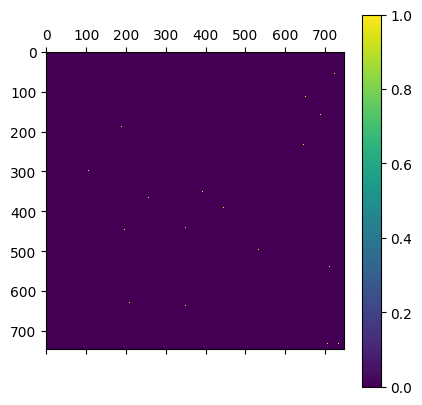

In [19]:
plt.matshow(all_trips)
plt.colorbar()
plt.show()

## Tensor Decomposition

In [20]:
!pip install tensorly

In [21]:
import tensorly as tl
from tensorly.decomposition import tucker

In [22]:
#Represent the trips as a tensor
tensor_trip = tl.tensor(trips_3darray, dtype='float64')

In [23]:
tensor_trip.shape

(747, 747, 672)

In [24]:
# Rank of Tucker decomposition
tucker_rank = [350, 350, 200]

In [25]:
core, factors = tucker(tensor_trip, rank=tucker_rank, init='random', tol=10e-5,random_state=12345)

In [26]:
#Convert the tucker tensor into a full tensor
tucker_rec = tl.tucker_to_tensor((core, factors))

In [69]:
factors[0].shape

(747, 350)

In [28]:
factors[1].shape

(747, 350)

In [29]:
factors[2].shape

(672, 200)

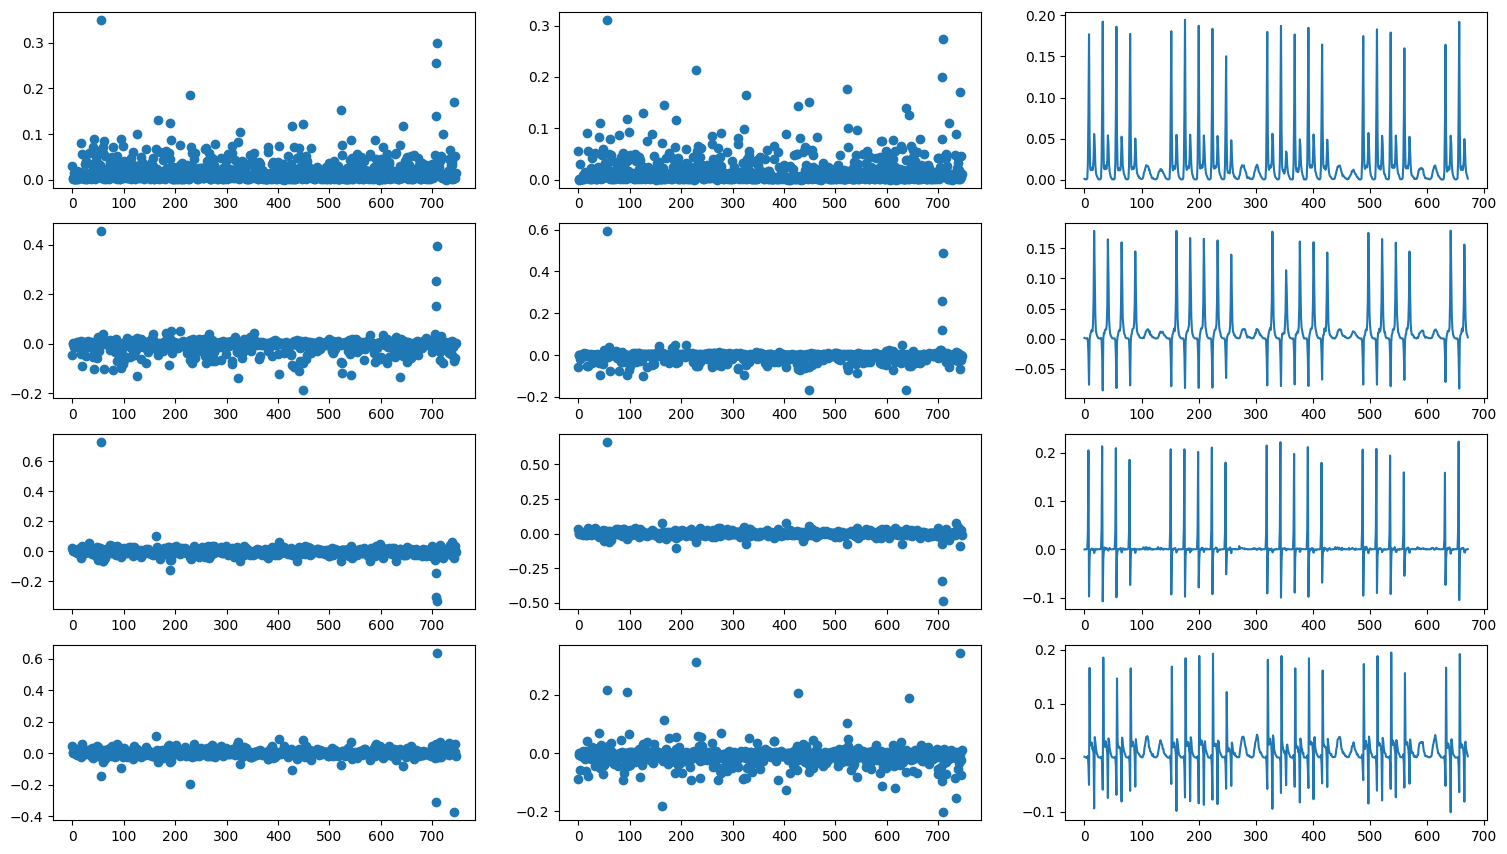

In [67]:
fig, axs = plt.subplots(4, 3)
fig.set_size_inches(18.5, 10.5)
axs[0, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[0])
axs[0, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[0])
axs[0, 2].plot(np.transpose(factors[2])[0])

axs[1, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[1])
axs[1, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[1])
axs[1, 2].plot(np.transpose(factors[2])[1])

axs[2, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[2])
axs[2, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[2])
axs[2, 2].plot(np.transpose(factors[2])[2])

axs[3, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[3])
axs[3, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[3])
axs[3, 2].plot(np.transpose(factors[2])[3])

In [61]:
import requests

In [62]:
response= requests.get('https://api.tfl.gov.uk/BikePoint/')
stations = response.json()

In [63]:
data =  pd.DataFrame()
s_names = []
s_lat = []
s_lon = []

NbBikes = []
NbEmptyDocks = []
NbDocks = []
NbStandardBikes = []
NbEBikes = []
s_id = []

In [64]:
len_lat = 0
for station in stations:
    s_names.append(station['commonName'])
    s_lat.append(float(station['lat']))
    s_lon.append(float(station['lon']))
    for add_property in station['additionalProperties']:
        if add_property['key'] == 'NbBikes':
            NbBikes.append(int(add_property['value']))
        if add_property['key'] == 'NbEmptyDocks':
            NbEmptyDocks.append(int(add_property['value']))
        if add_property['key'] == 'NbDocks':
            NbDocks.append(int(add_property['value']))
        if add_property['key'] == 'NbStandardBikes':
            NbStandardBikes.append(int(add_property['value']))
        if add_property['key'] == 'NbEBikes':
            NbEBikes.append(int(add_property['value']))
        if add_property['key'] == 'TerminalName':
            s_id.append(int(add_property['value']))


In [65]:
data['Station_name'] = s_names
data['s_lat'] = s_lat
data['s_lon'] = s_lon
data['s_num_bikes'] = NbBikes
data['s_num_empty_docks'] = NbEmptyDocks
data['s_num_std_bikes'] = NbStandardBikes
data['s_num_e-bikes'] = NbEBikes
data['s_num_docks'] = data['s_num_bikes'] + data['s_num_empty_docks']
data['s_id'] = s_id

In [66]:
data

,Station_name,s_lat,s_lon,s_num_bikes,s_num_empty_docks,s_num_std_bikes,s_num_e-bikes,s_num_docks,s_id
0,"River Street , Clerkenwell",51.529163,-0.109970,4,15,3,1,19,1023
1,"Phillimore Gardens, Kensington",51.499606,-0.197574,7,28,7,0,35,1018
2,"Christopher Street, Liverpool Street",51.521283,-0.084605,11,20,11,0,31,1012
3,"St. Chad's Street, King's Cross",51.530059,-0.120973,15,8,15,0,23,1013
4,"Sedding Street, Sloane Square",51.493130,-0.156876,19,7,18,1,26,3420
...,...,...,...,...,...,...,...,...,...
791,"Blenheim Crescent, Ladbroke Grove",51.515108,-0.208565,8,14,8,0,22,300090
792,"The Metropolitan, Portobello",51.520509,-0.200804,0,18,0,0,18,300244
793,"Bevington Road West, North Kensington",51.521200,-0.208888,16,8,15,1,24,300236
794,"Lansdowne Walk, Ladbroke Grove",51.509591,-0.204666,1,20,1,0,21,200065


In [68]:
# South East limits
se_limit_lat = 51.523811 # everthing lower than this value is south east
se_limit_lon = -0.101342 # everything greater than this value is south east

# East limits
e_limit_lat = 51.523811 # everything greater than this value is east
e_limit_lon = -0.022306 # everything greater than this is east

# South West limits
sw_limit_lat = 51.501631 # everthing lower than this value is south east
sw_limit_lon = -0.101342 # everything lower than this value is south east

# West limits
w_limit_lat = 51.501072  # everthing greater than this value is south east
w_limit_lon = -0.182406  # everthing lower than this value is south east

# Central limits
c_toplimit_lat = 51.501072 # everthing greater than this value is central
c_lowlimit_lat = 51.523811 # everything lower than this value is central

c_toplimit_lon = -0.101342 # everything lower than this value is central
c_lowlimit_lon = -0.182406 # everthing greater than this value is central

# North limits
n_toplimit_lon = -0.022306 # everything lower than this value is central
n_lowlimit_lon = -0.182406 # everthing greater than this value is central

n_lowlimit_lat = 51.523811 # everthing greater than this value is central

In [112]:
loc = []

In [113]:
for station in data.index:
    if data['s_lat'][station] > c_toplimit_lat and data['s_lat'][station]< c_lowlimit_lat and data['s_lon'][station]< c_toplimit_lon and data['s_lon'][station]>c_lowlimit_lon:
        loc.append(1) # Central
    elif data['s_lon'][station] < n_toplimit_lon and data['s_lon'][station] > n_lowlimit_lon and data['s_lat'][station] > n_lowlimit_lat:
        loc.append(2) # North
    elif data['s_lon'][station] < w_limit_lon and data['s_lat'][station] > w_limit_lat:
        loc.append(3) # West
    elif data['s_lon'][station] < sw_limit_lon and data['s_lat'][station] < sw_limit_lat:
        loc.append(4)  # South_West
    elif data['s_lon'][station] > e_limit_lon and data['s_lat'][station] > e_limit_lat:
        loc.append(5) # East
    elif data['s_lon'][station] > se_limit_lon and data['s_lat'][station] < se_limit_lat:
        loc.append(6) # South East
    else:
        loc.append('Other')

In [114]:
data['Area_loc'] = loc

In [115]:
data

,Station_name,s_lat,s_lon,s_num_bikes,s_num_empty_docks,s_num_std_bikes,s_num_e-bikes,s_num_docks,s_id,Area_loc
0,"River Street , Clerkenwell",51.529163,-0.109970,4,15,3,1,19,1023,2
1,"Phillimore Gardens, Kensington",51.499606,-0.197574,7,28,7,0,35,1018,4
2,"Christopher Street, Liverpool Street",51.521283,-0.084605,11,20,11,0,31,1012,6
3,"St. Chad's Street, King's Cross",51.530059,-0.120973,15,8,15,0,23,1013,2
4,"Sedding Street, Sloane Square",51.493130,-0.156876,19,7,18,1,26,3420,4
...,...,...,...,...,...,...,...,...,...,...
791,"Blenheim Crescent, Ladbroke Grove",51.515108,-0.208565,8,14,8,0,22,300090,3
792,"The Metropolitan, Portobello",51.520509,-0.200804,0,18,0,0,18,300244,3
793,"Bevington Road West, North Kensington",51.521200,-0.208888,16,8,15,1,24,300236,3
794,"Lansdowne Walk, Ladbroke Grove",51.509591,-0.204666,1,20,1,0,21,200065,3


In [116]:
data.loc[data.Station_name == 'Chepstow Villas, Notting Hill'].values[0][9]

3

In [120]:
color_stations = []
for station in total_uniq_stations:
  info_val = data.loc[data.Station_name == station].values
  if len(info_val)>0:
    color_stations.append(data.loc[data.Station_name == station].values[0][9])
  else:
    color_stations.append(7)

In [121]:
len(color_stations)


747

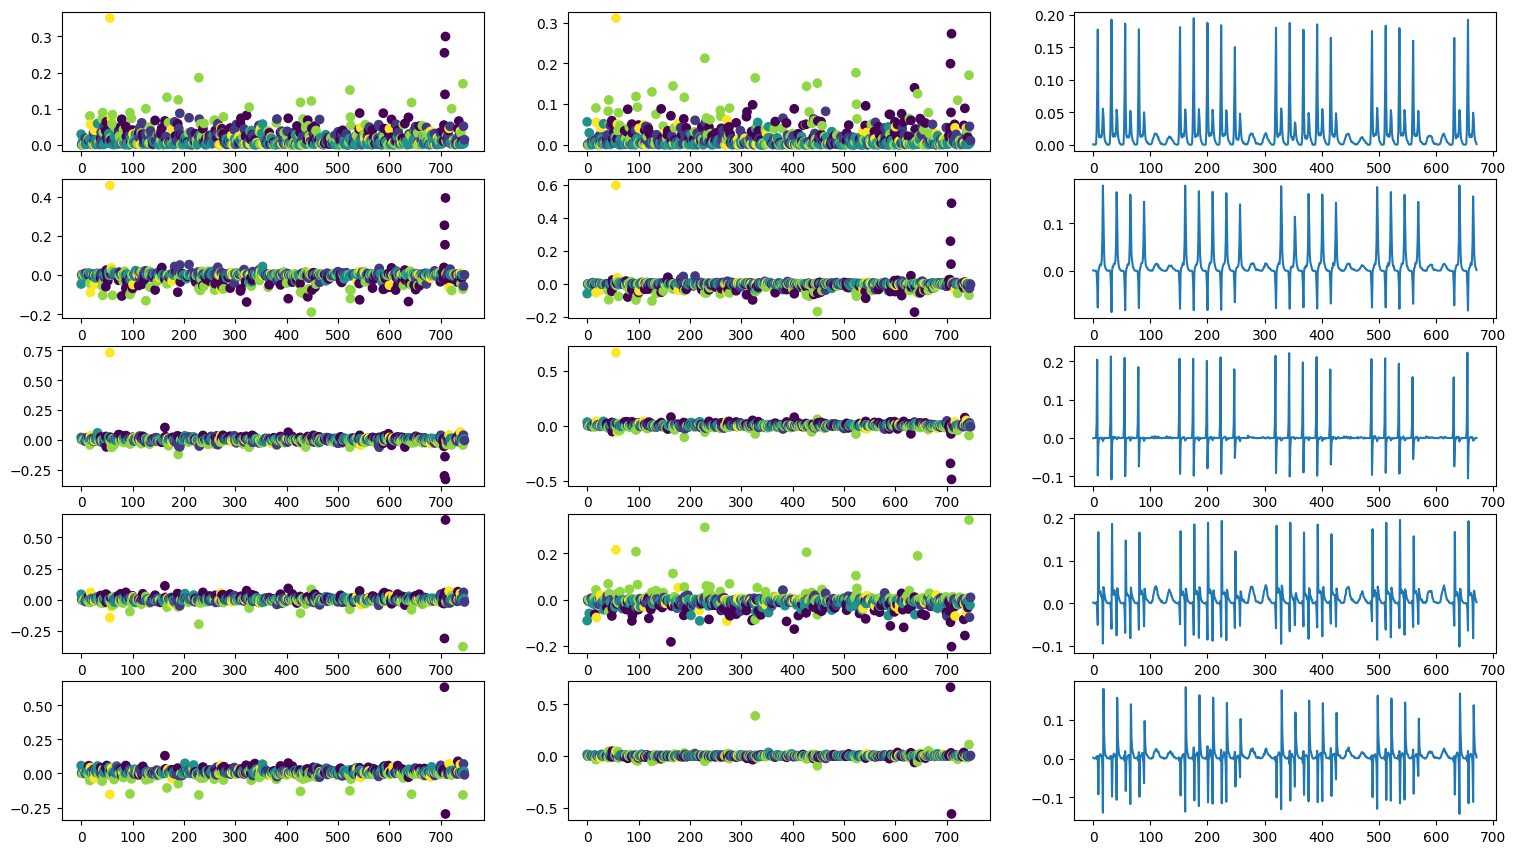

In [125]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(18.5, 10.5)
axs[0, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[0], c=color_stations)
axs[0, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[0], c=color_stations)
axs[0, 2].plot(np.transpose(factors[2])[0])

axs[1, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[1], c=color_stations)
axs[1, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[1], c=color_stations)
axs[1, 2].plot(np.transpose(factors[2])[1])

axs[2, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[2], c=color_stations)
axs[2, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[2], c=color_stations)
axs[2, 2].plot(np.transpose(factors[2])[2])

axs[3, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[3], c=color_stations)
axs[3, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[3], c=color_stations)
axs[3, 2].plot(np.transpose(factors[2])[3])

axs[4, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors[0])[4], c=color_stations)
axs[4, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors[1])[4], c=color_stations)
axs[4, 2].plot(np.transpose(factors[2])[4])

In [127]:
# Rank of Tucker decomposition
tucker_rank_2 = [8, 8, 8]

In [128]:
core_2, factors_2 = tucker(tensor_trip, rank=tucker_rank_2, init='random', tol=10e-5,random_state=12345)

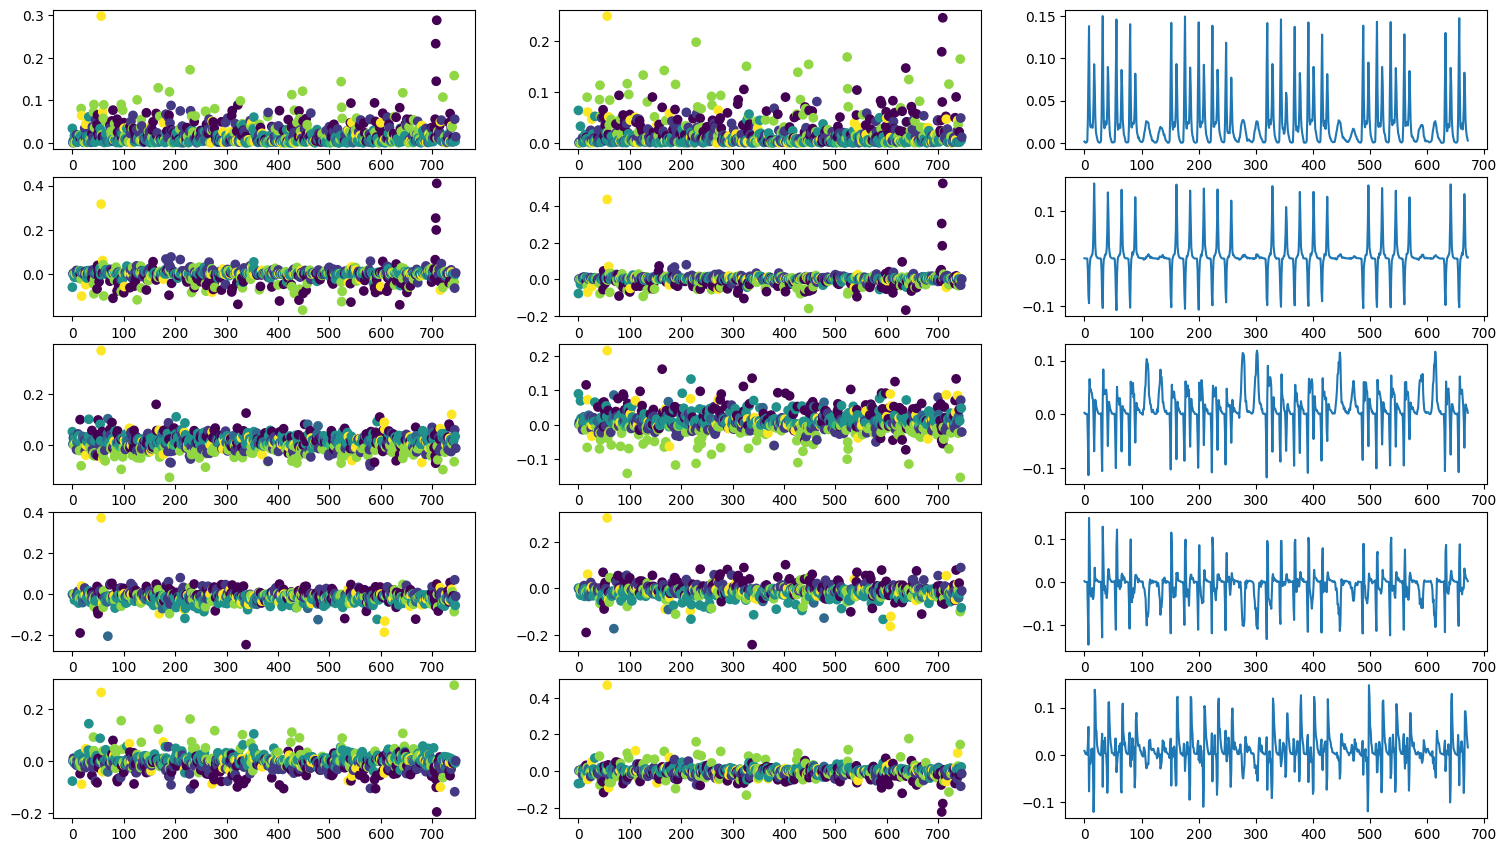

In [129]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(18.5, 10.5)
axs[0, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors_2[0])[0], c=color_stations)
axs[0, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors_2[1])[0], c=color_stations)
axs[0, 2].plot(np.transpose(factors_2[2])[0])

axs[1, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors_2[0])[1], c=color_stations)
axs[1, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors_2[1])[1], c=color_stations)
axs[1, 2].plot(np.transpose(factors_2[2])[1])

axs[2, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors_2[0])[2], c=color_stations)
axs[2, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors_2[1])[2], c=color_stations)
axs[2, 2].plot(np.transpose(factors_2[2])[2])

axs[3, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors_2[0])[3], c=color_stations)
axs[3, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors_2[1])[3], c=color_stations)
axs[3, 2].plot(np.transpose(factors_2[2])[3])

axs[4, 0].scatter(x=range(len(factors[0])), y=np.transpose(factors_2[0])[4], c=color_stations)
axs[4, 1].scatter(x=range(len(factors[1])), y=np.transpose(factors_2[1])[4], c=color_stations)
axs[4, 2].plot(np.transpose(factors_2[2])[4])